In [1]:
%matplotlib widget

# DEFAULTS

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from tqdm import tqdm
from scipy.integrate import simpson
import sys
sys.path.append("..")
from truncation import get_truncation


FORCES = ["LO", "NLO", "N2LO", "N3LO", "N4LO", "N4LO+"]
CUTOFF = [400, 450, 500, 550]

# plt.style.use(['science', 'retro'])

mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'DejaVu Sans'
mpl.rcParams['mathtext.it'] = 'DejaVu Sans:italic'
mpl.rcParams['mathtext.bf'] = 'DejaVu Sans:bold'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "DejaVu Sans"

plt.rc('text', usetex=True)
plt.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['lines.linewidth'] = 2

line_styles = {"LO": {"marker": "d", "markevery": 10, "markersize": 3, "color": "tab:cyan"},
               "NLO": {"marker": ".", "markevery": 10, "color": "orange"},
               "N2LO": {"ls":  (0, (5, 3)), "color": "green"},
               "N3LO": {"ls": "dotted", "color": "blue"},
               "N4LO": {"ls": (0, (5, 2, 0.8, 2, 0.8, 2)), "color": "red"},
               "N4LO+": {"color": "black"},
               "AV18": {"ls": (0, (5, 2, 1.3, 2,)), "color": "blueviolet"},
               "SIEGERT": {"color": "blue"},
               "1NC": {"color": "deeppink", "ls": "dashed"}
               }
ls_cutoff = {400: line_styles["N4LO"],
             450: line_styles["N4LO+"],
             500: line_styles["N2LO"],
             550: line_styles["N3LO"],
             }

exp_style = [
    {"fmt": "ok"},
    {"fmt": "ok", "markerfacecolor": "None", "markeredgecolor": "k"},
    {"fmt": "sk"},
    {"fmt": "^k"},
    {"fmt": "Xk"},
    {"fmt": "dk"},
]

trunc_colors = {
    "NLO": "bisque",
    "N2LO": "limegreen",
    "N3LO": "dodgerblue",
    "N4LO": "red",
    "N4LO+": "black",
}

marker_common = {"markersize": 6, "elinewidth": 0.9, "capsize": 2.5}


df_my = pd.read_csv("deuteron_all_data.csv")
df_my.T21D2 *= 2
df_my.T22D2 *= 2
df_my.T21D *= 2
df_my.T22D *= 2
df_my.AX *= -1
df_my.AX2 *= -1

OBSERVABLES = [ob for ob in df_my.columns.values if ob not in [
    "THCM", "angle", "CUTOFF", "FORCE"]]

my_energies = df_my.Energy.unique()
my_energies.sort()

# 60 MeV

In [65]:
df_exp = []
for i, fname in enumerate(os.listdir("ExpData/Asymetry/60mev/")):
    df_tmp = pd.read_csv(f'ExpData/Asymetry/60mev/{fname}')
    df_tmp["fname"] = fname.rstrip(".dat")
    df_exp.append(df_tmp)

/tmp/ipykernel_1867434/1114932358.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depre

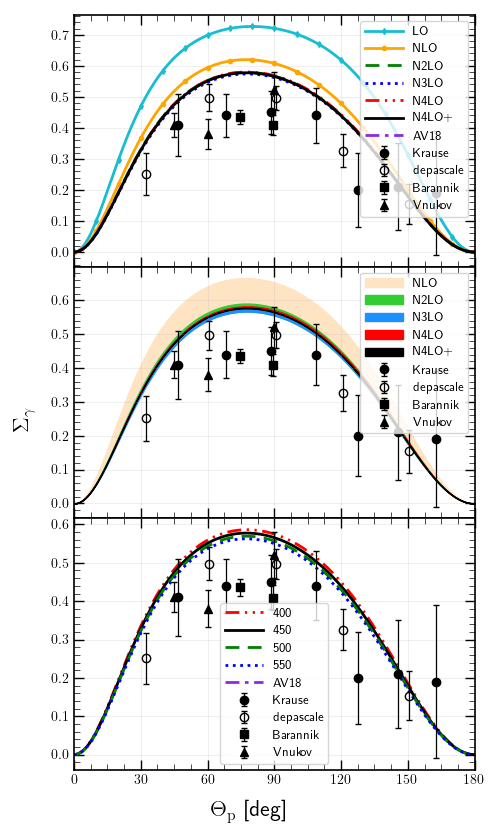

In [66]:
obs="AX2"
energy=60
cutoff=450
df=df_my
wave="SIEGERT"
ylabel="$\Sigma_\gamma$"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.Energy == energy) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[0].plot(df_tmp.angle, df_tmp[obs],
                **line_styles[force], label=force)
    if force != "LO":
        axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
                            df_tmp[obs].values-df_trunc[force].values, label=force,
                            color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    for i, df_tmp in enumerate(df_exp):
        ax.errorbar(df_tmp.theta, df_tmp.Sigma,
                    yerr=df_tmp.error, zorder=3, **exp_style[i], **marker_common
                    , label=df_tmp.fname[0])
    if j != 1:
        ax.plot(df_av18.angle, df_av18[obs],
                **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="best")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
# plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
#             dpi=600, facecolor="white")

# 20 MeV

In [79]:
df_exp = []
for i, fname in enumerate(os.listdir("ExpData/Asymetry/20mev/")):
    df_tmp = pd.read_csv(f'ExpData/Asymetry/20mev/{fname}')
    df_tmp["fname"] = fname.rstrip(".dat")
    df_tmp["theta"] = 180 - df_tmp["theta_n"]
    df_exp.append(df_tmp)

/tmp/ipykernel_1867434/1889506898.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("angle", inplace=True)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  maxdiff.append(df_diff[FORCES[force_num-1]]*EPSILON)
/home/vitalii/Jagielllonian_work/THESIS/thesis/PlotData/Deuteron/../truncation.py:65: FutureWarning: The series.append method is depre

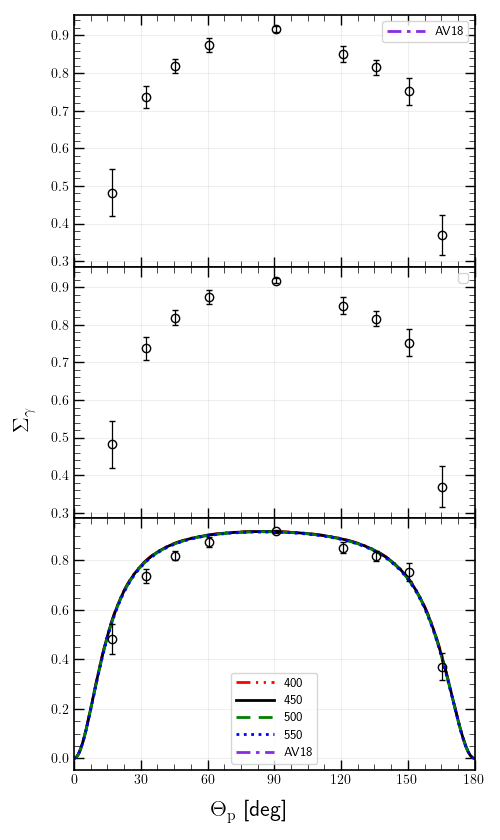

In [83]:
obs="AX2"
energy=20
cutoff=450
df=df_my
wave="SIEGERT"
ylabel="$\Sigma_\gamma$"
df_tmp = df[(df.CUTOFF == cutoff) &
            (df.Energy == energy) &
            (df.WAVE == wave)]
df_tmp.sort_values("angle", inplace=True)
df_piv = df_tmp.pivot(index="angle", columns="FORCE")[obs].reindex(FORCES, axis=1)
df_trunc = get_truncation(df_piv, energy)

fig = plt.figure(figsize=(5, 8.4))
gs = fig.add_gridspec(nrows=3, hspace=0)
axes = gs.subplots(sharex=True)
fig.supxlabel("$\Theta_\mathrm{p}$ [deg]", y=0.02, size=16)
if not ylabel:
    ylabel = obs
fig.supylabel(ylabel, x=0.03, size=16)
for force in FORCES:
    df_tmp = df[(df.FORCE == force) &
                (df.CUTOFF == cutoff) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    # axes[0].plot(df_tmp.angle, df_tmp[obs],
    #             **line_styles[force], label=force)
    # if force != "LO":
    #     axes[1].fill_between(df_tmp.angle, df_tmp[obs].values+df_trunc[force].values,
    #                         df_tmp[obs].values-df_trunc[force].values, label=force,
    #                         color=trunc_colors[force])
    # break
for cut in CUTOFF:
    df_tmp = df[(df.FORCE == "N4LO+") &
                (df.CUTOFF == cut) &
                (df.Energy == energy) &
                (df.WAVE == "SIEGERT")]
    axes[2].plot(df_tmp.angle, df_tmp[obs],
                **ls_cutoff[cut], label=cut)
df_av18 = df[(df.FORCE == "AV18") & (df.Energy == energy)]
for j, ax in enumerate(axes):
    for i, df_tmp in enumerate(df_exp):
        ax.errorbar(df_tmp.theta, df_tmp.Sigma,
                    yerr=df_tmp.error, zorder=3, **exp_style[1], **marker_common)
                    # , label=df_tmp.fname[0])
    if j != 1:
        ax.plot(df_av18.angle, df_av18[obs],
                **line_styles["AV18"], label="AV18")

    ax.legend(fontsize=9, handlelength=3, loc="best")
    
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.tick_params(which='minor', direction='in', length=4,
                width=0.5, top=True, right=True)
    ax.tick_params(which='major', direction='in',
                length=7, width=1, top=True, right=True, zorder=1)
    ax.set_xticks(np.arange(0, 180+j-1, 30))
    ax.set_xlim([0, 180])
    ax.grid(alpha=0.2)
    ax.set_zorder(-1)
fig.tight_layout()
plt.savefig(f"../Figures_De/{obs}_{energy}mev.pdf",
            dpi=600, facecolor="white")

In [89]:
df_tmp = df_my[(df_my.FORCE == "N4LO+") &
                (df_my.CUTOFF == 450) &
                (df_my.angle == 90) &
                (df_my.WAVE == "SIEGERT")]
df_tmp.sort_values("Energy", inplace=True)

/tmp/ipykernel_1867434/309558329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp.sort_values("Energy", inplace=True)


In [97]:
df_delbianco = pd.read_csv("ExpData/Asymetry/90deg/delbianco.dat")
df_depascale = pd.read_csv("ExpData/Asymetry/90deg/depascale.dat")

In [95]:
df_delbianco.head()

,energy,Sigma,error
0,9.9,0.97,0.01
1,14.8,0.92,0.02
2,19.8,0.92,0.01
3,29.0,0.81,0.03
4,38.3,0.66,0.03


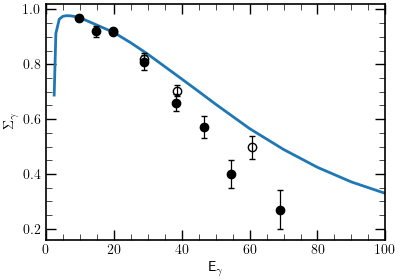

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.8), constrained_layout=True)
ax.plot(df_tmp.Energy, df_tmp["AX2"])
ax.errorbar(df_delbianco.energy, df_delbianco.Sigma,
                    yerr=df_delbianco.error, zorder=3, **exp_style[0], **marker_common)
ax.errorbar(df_depascale.energy, df_depascale.Sigma,
                    yerr=df_depascale.error, zorder=3, **exp_style[1], **marker_common)
ax.set_xlim([0, 100])
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.tick_params(axis="y", which='minor', direction='in', length=4,
                    width=0.5, top=True, right=True)
ax.tick_params(which='minor', direction='in', length=4,
            width=0.5, top=True, right=True)
ax.tick_params(which='major', direction='in',
            length=7, width=1, top=True, right=True, zorder=1)
ax.set_ylabel("$\Sigma_\gamma$")
ax.set_xlabel("E$_\gamma$")
plt.show()
fig.savefig("../Figures_De/AX2_90deg.pdf",
            dpi=600, facecolor="white")